# Backpropagation Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
import pdb
import copy
from IPython.core.display import display
import time

import warnings
warnings.filterwarnings('ignore')

import pprint
pp = pprint.PrettyPrinter(indent=4)

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm.

## Code requirements
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [15]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, momentum=0, shuffle=False,
                 hidden_layer_widths=None, num_epochs=200,
                 max_epoch_no_change=10, early_stopping=False,
                 validation_size=0.1, tol=1e-4,
                 random_seed=0):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes. (and then one more for the bias node)
            For example: input width 1, then hidden layer will be 3 nodes
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.tol = tol
        self.num_epochs = num_epochs
        self.max_epoch_no_change = max_epoch_no_change
        self.early_stopping = early_stopping
        self.random_seed = random_seed

        if self.early_stopping:
            self.validation_size = validation_size
        else:
            self.validation_size = 0

        self.bssf = None
        self.bssf_mse = np.inf
        self.activations = []


    def fit(self, X, y, initial_weights=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        self.n_inputs = X.shape[1]
        self.n_outputs = y.shape[1]
        self.n_data = X.shape[0]
        self.validation_mse = []
        self.validation_classification_accuracy = []
        self.train_mse = []
        self.train_classification_accuracy = []
        self.weights = self.initialize_weights() if initial_weights is None else initial_weights
        self.momentums = self.initialize_momentums()
        num_epochs_no_change = 0

        if self.shuffle:
                X, y = self._shuffle_data(X, y)

        # Get the validation set
        val_cutoff = int(self.n_data * self.validation_size)
        X, X_val, y, y_val = X[val_cutoff:, :], X[:val_cutoff, :], y[val_cutoff:, :], y[:val_cutoff, :]

        # Train
        for epoch in range(self.num_epochs):

            # Shuffle the data each epoch
            if self.shuffle:
                X, y = self._shuffle_data(X, y)

            for i in range(X.shape[0]):
                input = X[i, :]
                target = y[i, :]

                # One forward pass
                predicted = self._forward(input)

                # One backward pass (backpropagation)
                self._backward(target, input)

                pp.pprint(self.weights)

            # Record train classification accuracy of epoch
            train_score = self.score(X, y)
            self.train_classification_accuracy.append(train_score)

            # Record train MSE of epoch
            self.train_mse.append(self.mse(X, y))

            if self.early_stopping:

                # Record validation classification accuracy of epoch
                validation_score = self.score(X_val, y_val)
                self.validation_classification_accuracy.append(validation_score)

                # Record validation MSE of epoch
                val_mse = self.mse(X_val, y_val)
                self.validation_mse.append(val_mse)

                # If the validation accuracy of this epoch is
                #  better than BSSF, update BSSF and reset epochs
                #  since no change
                if val_mse < self.bssf_mse:
                    self.bssf = copy.deepcopy(self.weights)
                    self.bssf_mse = val_mse
                    num_epochs_no_change = 0

                # If validation accuracy hasn't improved from BSSF
                #  by margin of tolerance, increment number of epochs
                #  no change
                if val_mse > (self.bssf_mse - self.tol):
                    num_epochs_no_change += 1
                else:
                    # self.previous_val_mse = val_mse
                    num_epochs_no_change = 0

                # End training if no improvement in accuracy after
                #  max_epochs_no_change epochs
                if num_epochs_no_change >= self.max_epoch_no_change:
                    break

        return self

    def _forward(self, input):
        self.nets = []
        self.activations = []

        for i in range(len(self.weights)):
            w = self.weights[i]
            if i == 0: x = input            # Data input to first hidden layer
            else: x = self.activations[-1]  # Subsequent hidden layers to output layer
            x = np.append(x, [1], axis=0)   # Add bias input
            net = np.matmul(np.transpose(w), x)
            self.nets.append(net)
            activation = self._f(net)
            self.activations.append(activation)
        return activation

    def _backward(self, target, input):

        self.errors = []

        # Compute the errors for each layer
        for i in range(len(self.activations) - 1, -1, -1):
            activations_js = self.activations[i]

            if i == len(self.activations) - 1:
                # Output Layer
                errors = np.subtract(target, activations_js) * activations_js * np.subtract(1, activations_js)
                self.errors.insert(0, errors)
            else:
                # Hidden layers
                W = self.weights[i + 1]
                errors_ks = self.errors[0]
                errors_js = []
                for j in range(self.hidden_layer_widths[i]):
                    error_j = 0
                    for k in range(len(errors_ks)):
                        error_k = errors_ks[k]
                        w_j_k = W[j][k]
                        Z_j = activations_js[j]
                        error_j += error_k * w_j_k * Z_j * (1 - Z_j)
                    errors_js.append(error_j)
                self.errors.insert(0, errors_js)

        # Now that errors are computed, we can update the weights (forward through network)
        for m in range(len(self.weights)):
            W = self.weights[m]
            errors_js = self.errors[m]
            if m == 0:
                activations_is = input
            else:
                activations_is = self.activations[m - 1]

            # Add bias input to activations
            activations_is = np.append(activations_is, [1], axis=0)

            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    delta_w = self.lr * errors_js[j] * activations_is[i] + \
                                            self.momentum * self.momentums[m][i][j]
                    self.weights[m][i][j] = self.weights[m][i][j] + delta_w
                    self.momentums[m][i][j] = delta_w

    def _f(self, X):
        # Sigmoid activation
        return np.divide(1,
                         np.add(1, np.exp(-X)))

    def _f_prime(self, X):
        # Derivative of sigmoid
        Z = self._sigmoid(X)
        return Z * np.subtract(1, Z)

    def _classify(self, X):
        return np.where(X < 0.5, 0, 1)

    def _loss(self, target_class, predictions):
        pred_class = np.argmax(predictions)
        return

    def _add_bias(self, X):
        bias_col = np.ones((X.shape[0], 1))
        return np.append(X, bias_col, 1)

    def initialize_momentums(self):
        momentums = copy.deepcopy(self.weights) # create an array with same dimensions as weights
        for k in range(len(momentums)):
            for i in range(momentums[k].shape[0]):
                for j in range(momentums[k].shape[1]):
                    momentums[k][i][j] = 0
        return momentums

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        net = self._forward(X)
        return np.where(net >= 0.5, 1, 0)

    def initialize_weights(self):
        """ Initialize weights for perceptron. Don't forget the bias!

        Returns:

        """
        weights = []

        # Create weights for input layer to first hidden layer
        np.random.seed(self.random_seed)
        w = np.random.normal(loc=0.0, scale=1.0, size=(self.n_inputs + 1, self.hidden_layer_widths[0]))
        weights.append(w)

        # All other weights
        for i in range(len(self.hidden_layer_widths)):
            n_left_nodes = self.hidden_layer_widths[i]

            if i == len(self.hidden_layer_widths) - 1:
                n_right_nodes = self.n_outputs
            else:
                n_right_nodes = self.hidden_layer_widths[i + 1]

            np.random.seed(self.random_seed)
            w = np.random.normal(loc=0, scale=1, size=(n_left_nodes + 1, n_right_nodes))
            weights.append(w)

        return weights

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self.predict(X[i, :]))
        predictions = np.array(predictions)
        correct = np.where(predictions == y, 1, 0)
        return np.mean(correct)

    def bssf_score(self, X, y):
        prev_weights = copy.deepcopy(self.weights)
        self.weights = self.bssf
        score = self.score(X, y)
        self.weights = copy.deepcopy(prev_weights)
        return score

    def mse(self, X, y):
        predictions = []

        for i in range(X.shape[0]):
            input = X[i, :]
            output = self._forward(input)
            predictions.append(output)

        predictions = np.array(predictions)
        mse = ((predictions - y)**2).mean()
        return mse

    def _shuffle_data(self, X, y):
        """
            Shuffle the data! This _ prefix suggests that this method should
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D
            array, rather than shuffling X and y exactly the same way,
            independently.
        """
        arr = np.concatenate((X, y), axis=1)
        np.random.seed(self.random_seed)
        np.random.shuffle(arr)

        return arr[:, :self.n_inputs], arr[:, self.n_inputs:]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

    def print_weights(self):
        print("Weights:")
        for weights in self.weights:
            print(weights)
            print()

    def print_errors(self):
        print("Error values:")
        for errors in self.errors:
            print(errors)


## 1.1

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv)

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$

$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv)

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$

$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [17]:
# Load debug data
linsep_data = arff.loadarff('datasets/linsep2nonorigin.arff')
debugDF = pd.DataFrame(linsep_data[0])
debugDF['class'] = pd.to_numeric(debugDF['class'])

y_debug = pd.get_dummies(debugDF.iloc[:,-1]).to_numpy()
X_debug = debugDF.iloc[:, 0:-1].to_numpy()

def create_weights_zero(n_inputs, n_outputs, hidden_layer_widths):
    weights = []
    # Create weights for input layer to first hidden layer
    w1 = np.zeros((n_inputs + 1, hidden_layer_widths[0]))
    weights.append(w1)

    # Create weights for hidden layer to output layer
    w2 = np.zeros((hidden_layer_widths[0] + 1, n_outputs))
    weights.append(w2)
    return weights

# Train on debug data
weights = create_weights_zero(2, 2, [4])

mlp = MLP(lr=0.1,
          momentum=0.5,
          shuffle=False,
          hidden_layer_widths=[4],
          num_epochs=1,
          max_epoch_no_change=10,
          early_stopping=False,
          validation_size=0,
          tol=np.NINF,
          random_seed=0)

mlp.fit(X_debug, y_debug, initial_weights=weights)

print("Accuracy: {}".format(mlp.score(X_debug, y_debug)))

# Print weights
mlp.print_weights()

Epoch: 0
Training instance 1
Weights after 1 training instance:
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])
array([[-0.00625,  0.00625],
       [-0.00625,  0.00625],
       [-0.00625,  0.00625],
       [-0.00625,  0.00625],
       [-0.0125 ,  0.0125 ]])


Training instance 2
Weights after 2 training instance:
array([[-1.15704653e-05, -1.15704653e-05, -1.15704653e-05,
        -1.15704653e-05],
       [ 3.08545741e-05,  3.08545741e-05,  3.08545741e-05,
         3.08545741e-05],
       [ 3.85682176e-05,  3.85682176e-05,  3.85682176e-05,
         3.85682176e-05]])
array([[-0.01554591,  0.01554591],
       [-0.01554591,  0.01554591],
       [-0.01554591,  0.01554591],
       [-0.01554591,  0.01554591],
       [-0.03109183,  0.03109183]])


Training instance 3
Weights after 3 training instance:
array([[-3.61658996e-05, -3.61658996e-05, -3.61658996e-05,
        -3.61658996e-05],
       [ 7.44971637e-05,  7.44971637e-05,  7.44971637e-05,
         7.44971637e-05]

### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [4]:
# Load evaluation data
banknote_data = arff.loadarff("datasets/data_banknote_authentication.arff")
banknoteDF = pd.DataFrame(banknote_data[0])
class_dummies = pd.get_dummies(banknoteDF[['class']])
class_dummies.columns = ['class_0', 'class_1']
banknoteDF.drop(columns=['class'], inplace=True)
banknoteDF['class_0'], banknoteDF['class_1'] = class_dummies['class_0'], class_dummies['class_1']

X_banknote = banknoteDF.iloc[:, 0:4].to_numpy()
y_banknote = banknoteDF.iloc[:, 4:].to_numpy()

# Train on evaluation data
weights = create_weights_zero(4, 2, [4])

mlp = MLP(lr=0.1,
          momentum=0.5,
          shuffle=False,
          hidden_layer_widths=[4],
          num_epochs=10,
          max_epoch_no_change=10,
          early_stopping=False,
          validation_size=0,
          tol=np.NINF,
          random_seed=0)

mlp.fit(X_banknote, y_banknote, initial_weights=weights)

# Print weights
mlp.print_weights()

Weights:
[[ 1.63828721  1.63828721  1.63828721  1.63828721]
 [ 1.09612249  1.09612249  1.09612249  1.09612249]
 [ 1.23447594  1.23447594  1.23447594  1.23447594]
 [ 0.39269487  0.39269487  0.39269487  0.39269487]
 [-2.09316151 -2.09316151 -2.09316151 -2.09316151]]

[[ 1.81695611 -1.81695611]
 [ 1.81695611 -1.81695611]
 [ 1.81695611 -1.81695611]
 [ 1.81695611 -1.81695611]
 [-4.17098071  4.17098071]]



## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

,sepallength,sepalwidth,petallength,petalwidth,b'Iris-setosa',b'Iris-versicolor',b'Iris-virginica'
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0


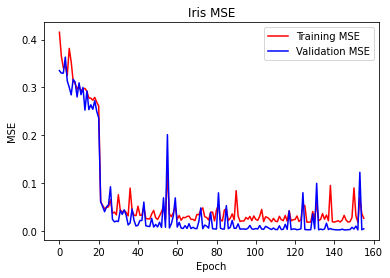

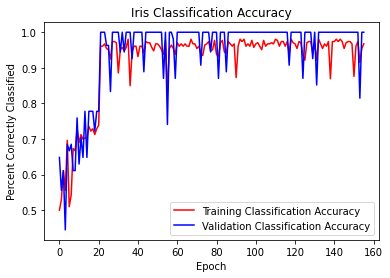

Iris Test BSSF Accuracy: 0.9667


In [65]:
# Iris Classification
iris_data = arff.loadarff("datasets/iris.arff")
irisDF = pd.DataFrame(iris_data[0])
irisDF = pd.concat([irisDF, pd.get_dummies(irisDF['class'])], axis=1) \
    .drop(columns=['class'])
display(irisDF.head(3))

X_iris = irisDF.iloc[:, :4].to_numpy()
y_iris = irisDF.iloc[:, 4:].to_numpy()

n_inputs = X_iris.shape[1]
iris_hidden_layer_widths = [2*n_inputs]

X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=2)

mlp = MLP(lr=0.1,
          momentum=0.5,
          shuffle=True,
          hidden_layer_widths=iris_hidden_layer_widths,
          num_epochs=200,
          max_epoch_no_change=10,
          early_stopping=True,
          validation_size=0.15,
          tol=1e-4,
          random_seed=0)

mlp.fit(X=X_iris_train, y=y_iris_train)

train_mse = mlp.train_mse
train_classification_accuracy = mlp.train_classification_accuracy
val_mse = mlp.validation_mse
val_classification_accuracy = mlp.validation_classification_accuracy

plt.plot(train_mse, color='red', label="Training MSE")
plt.plot(val_mse, color='blue', label='Validation MSE')
plt.legend()
plt.title("Iris MSE")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.savefig('figures/iris-mse.png', dpi=300)
plt.show()

plt.plot(train_classification_accuracy, color='red', label='Training Classification Accuracy')
plt.plot(val_classification_accuracy, color='blue', label='Validation Classification Accuracy')
plt.legend()
plt.title("Iris Classification Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Percent Correctly Classified')
plt.savefig('figures/iris-classification-accuracy.png', dpi=300)
plt.show()

iris_bssf_test_score = mlp.bssf_score(X_iris_test, y_iris_test)
print("Iris Test BSSF Accuracy: %0.4f" % iris_bssf_test_score)

In [62]:
print(n_inputs)

4


## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn.

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [45]:
# Load dataset
vowel_data = arff.loadarff("datasets/vowel.arff")
vowelDF = pd.DataFrame(vowel_data[0])
vowelDF.drop(columns=['Speaker Number', 'Sex', 'Train or Test'], inplace=True)

XDF_vowel = vowelDF.iloc[:, :-1]
yDF_vowel = vowelDF.iloc[:, -1:]

yDF_vowel = pd.concat([yDF_vowel, pd.get_dummies(yDF_vowel['Class'])], axis=1) \
    .drop(columns=['Class'])

display(XDF_vowel.head(2))
display(yDF_vowel.head(2))

X_vowel = XDF_vowel.to_numpy()
y_vowel = yDF_vowel.to_numpy()

X_vowel_train, X_vowel_test, y_vowel_train, y_vowel_test = train_test_split(X_vowel, y_vowel,
                                                                            test_size=0.2, random_state=2)

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488


,b'hAd',b'hEd',b'hId',b'hOd',b'hUd',b'hYd',b'had',b'hed',b'hid',b'hod',b'hud'
0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,0


0.01
0.08249999999999999
0.155
0.22749999999999998
0.3


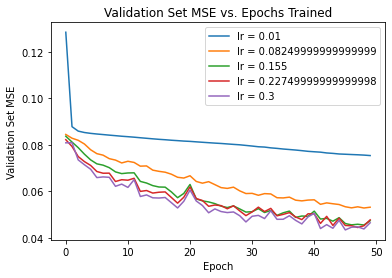

In [36]:
# learning_rates = [0.07, 0.1, 0.2, 0.4, 0.8]
learning_rates = np.linspace(0.01, 0.3, 5)
n_inputs = X_vowel.shape[1]
n_outputs = y_vowel.shape[1]
hidden_layer_widths = [2*X_vowel.shape[1]]

# Train on each dataset
bssf_lr = None
bssf_mse = np.inf
bssf_weights = None
vowel_bssf_test_score = None

for learning_rate in learning_rates:
    print(learning_rate)
    mlp = MLP(lr = learning_rate,
              momentum=0,
              shuffle=True,
              hidden_layer_widths=hidden_layer_widths,
              num_epochs=50,
              max_epoch_no_change=10,
              early_stopping=True,
              validation_size=0.15,
              tol=1e-4,
              random_seed=2)

    mlp.fit(X_vowel_train, y_vowel_train)

    if mlp.bssf_mse < bssf_mse:
        bssf_lr = learning_rate
        bssf_mse = mlp.bssf_mse
        bssf_weights = mlp.get_weights()
        vowel_bssf_test_score = mlp.score(X_vowel_test, y_vowel_test)

    val_mse = mlp.validation_mse
    plt.plot(val_mse, label="lr = " + str(learning_rate))

plt.legend()
plt.title('Validation Set MSE vs. Epochs Trained')
plt.ylabel('Validation Set MSE')
plt.xlabel('Epoch')
plt.savefig('figures/vowel-mse-vs-epochs.png', dpi=300)
plt.show()

In [38]:
# Iris baseline
X_iris = irisDF.iloc[:, :4].to_numpy()
y_iris = irisDF.iloc[:, 4:].to_numpy()
iris_y_hat = np.zeros(y_iris.shape)
for i in range(iris_y_hat.shape[0]):
    index = np.random.randint(low=0, high=iris_y_hat.shape[1], size=1)[0]
    iris_y_hat[i, index] = 1
iris_baseline_correct = np.mean(np.where(iris_y_hat == y_iris, 1, 0))

print("Iris baseline accuracy: {}".format(iris_baseline_correct))

# Vowel baseline
vowel_y_hat = np.zeros(y_vowel.shape)
for i in range(vowel_y_hat.shape[0]):
    index = np.random.randint(low=0, high=vowel_y_hat.shape[1], size=1)[0]
    vowel_y_hat[i, index] = 1
vowel_baseline_correct = np.mean(np.where(vowel_y_hat == y_vowel, 1, 0))
print("Vowel baseline accuracy: {}".format(vowel_baseline_correct))

Iris baseline accuracy: 0.5066666666666667
Vowel baseline accuracy: 0.8347107438016529


In [64]:
print("Vowel Test BSSF Accuracy: %0.4f" % vowel_bssf_test_score)
print("Iris Test BSSF Accuracy : %0.4f" % iris_bssf_test_score)

Vowel Test BSSF Accuracy: 0.9293
Iris Test BSSF Accuracy : 0.9667


## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates.
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies.
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.


*Discuss Intuition here*

A lower learning rate provides more stable learning with a steady decrease in error. A learning rate
that's too low takes too long to train. A learning rate that's too high is unstable in learning
and levels off in reducing error too soon. A learning rate that's much too high
will bounce all over the place. A good learning rate will reduce error at a
steady pace but fast enough that it doesn't take too long to train.

The vowel dataset is more difficult than the iris dataset because the vowel dataset has more input features
and output classes. This mean that the MLP for the vowel dataset is much larger and therefore has more
parameters to train.

In my training runs, baseline accuracy for the Iris dataset was 0.56, where baseline is accuracy
if classes are chosen at random. After training, the best solution for the Iris dataset had a test
accuracy of 0.98. Baseline accuracy for the Vowel dataset is 0.83. After training, the best solution
for the Vowel dataset had a test accuracy of 0.93.

For the Vowel dataset features, Train or Test, speaker, and gender don't make sense to keep as features because
they would have little-to-no effect on the vowel being pronounced. In my training,
I kept all other features (Feature 0 through Feature 9) because, as they were
labeled "features," were probably the intended explanatory variables.

## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy.
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

In [40]:
best_lr = 0.01
n_hidden_nodes = 1
best_n_hidden_nodes = None
best_mse = np.inf
n_hidden_nodes_vs_train_mse = []
n_hidden_nodes_vs_val_mse = []
n_hidden_nodes_vs_test_accuracy = []
tol = 1e-4

while 1:
    print("Number of hidden nodes: {}".format(n_hidden_nodes))

    mlp = MLP(lr = best_lr,
              momentum=0.9,
              shuffle=True,
              hidden_layer_widths=[n_hidden_nodes],
              num_epochs=50,
              max_epoch_no_change=5,
              early_stopping=True,
              validation_size=0.15,
              tol=1e-4,
              random_seed=2)

    mlp.fit(X_vowel_train, y_vowel_train)

    val_mse = mlp.bssf_mse

    n_hidden_nodes_vs_train_mse.append((n_hidden_nodes, np.min(mlp.train_mse)))
    n_hidden_nodes_vs_val_mse.append((n_hidden_nodes, np.min(mlp.validation_mse)))
    n_hidden_nodes_vs_test_accuracy.append((n_hidden_nodes, mlp.score(X_vowel_train, y_vowel_train)))

    if val_mse < (best_mse - tol):
        best_mse = val_mse
        best_n_hidden_nodes = n_hidden_nodes
        n_hidden_nodes *= 2
    else:
        break

Number of hidden nodes: 1
Number of hidden nodes: 2
Number of hidden nodes: 4
Number of hidden nodes: 8
Number of hidden nodes: 16
Number of hidden nodes: 32
Number of hidden nodes: 64


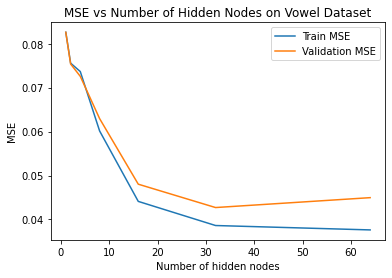

Number of hidden nodes: 1, Test accuracy: 0.9090909090909091
Number of hidden nodes: 2, Test accuracy: 0.9142561983471075
Number of hidden nodes: 4, Test accuracy: 0.9132231404958677
Number of hidden nodes: 8, Test accuracy: 0.9214876033057852
Number of hidden nodes: 16, Test accuracy: 0.9454775022956842
Number of hidden nodes: 32, Test accuracy: 0.9533976124885216
Number of hidden nodes: 64, Test accuracy: 0.9522497704315886


In [41]:
# Plot graph
list_n_hidden_nodes, list_train_mse = zip(*n_hidden_nodes_vs_train_mse)
plt.plot(list_n_hidden_nodes, list_train_mse, label='Train MSE')
list_n_hidden_nodes, list_val_mse = zip(*n_hidden_nodes_vs_val_mse)
plt.plot(list_n_hidden_nodes, list_val_mse, label='Validation MSE')
plt.legend()
plt.xlabel('Number of hidden nodes')
plt.ylabel('MSE')
plt.title('MSE vs Number of Hidden Nodes on Vowel Dataset')
plt.savefig('figures/vowel-mse-vs-num-hidden-nodes.png')
plt.show()

# Show the score for each number of hidden nodes
for tuple in n_hidden_nodes_vs_test_accuracy:
    print("Number of hidden nodes: {}, Test accuracy: {}".format(tuple[0], tuple[1]))

*Discuss Hidden Layer Nodes here*

From the output above, we can see that generally as the number of hidden nodes increases the MSE
decreases until adding new hidden nodes has no significant effect. Similarly, adding more
hidden nodes increases test accuracy.


## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy.
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

In [28]:
momentums = np.arange(0.1, 1.0, 0.1)
best_lr = 0.01
momentum_vs_num_epochs_until_convergence = []
momentum_vs_test_set_accuracy = []

for momentum in momentums:
    print("Momentum: {}".format(momentum))

    mlp = MLP(lr = best_lr,
              momentum=momentum,
              shuffle=True,
              hidden_layer_widths=[best_n_hidden_nodes],
              num_epochs=1000,
              max_epoch_no_change=5,
              early_stopping=True,
              validation_size=0.15,
              tol=1e-4,
              random_seed=2)
    mlp.fit(X_vowel_train, y_vowel_train)

    num_epochs_till_convergence = len(mlp.validation_mse)
    momentum_vs_num_epochs_until_convergence.append((momentum, num_epochs_till_convergence))

    test_accuracy = mlp.score(X_vowel_test, y_vowel_test)
    momentum_vs_test_set_accuracy.append((momentum, test_accuracy))

Momentum: 0.1
Momentum: 0.2
Momentum: 0.30000000000000004
Momentum: 0.4
Momentum: 0.5
Momentum: 0.6
Momentum: 0.7000000000000001
Momentum: 0.8
Momentum: 0.9


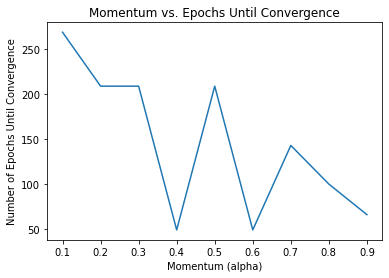

Momentum: 0.1, Test accuracy: 0.9228650137741047
Momentum: 0.2, Test accuracy: 0.9233241505968779
Momentum: 0.30000000000000004, Test accuracy: 0.9228650137741047
Momentum: 0.4, Test accuracy: 0.9136822773186409
Momentum: 0.5, Test accuracy: 0.9306703397612488
Momentum: 0.6, Test accuracy: 0.9136822773186409
Momentum: 0.7000000000000001, Test accuracy: 0.9288337924701561
Momentum: 0.8, Test accuracy: 0.9338842975206612
Momentum: 0.9, Test accuracy: 0.9348025711662076


In [42]:
# Plot momentum vs epochs till convergence
list_momentums, list_num_epochs_till_convergence = zip(*momentum_vs_num_epochs_until_convergence)
plt.plot(list_momentums, list_num_epochs_till_convergence)
plt.title("Momentum vs. Epochs Until Convergence")
plt.xlabel('Momentum (alpha)')
plt.ylabel('Number of Epochs Until Convergence')
plt.savefig('figures/vowel-momentum-vs-epochs', dpi=300)
plt.show()

# Show the score for each momentum
for tuple in momentum_vs_test_set_accuracy:
    print("Momentum: {}, Test accuracy: {}".format(tuple[0], tuple[1]))

*Discuss Momentum here*

As the momentum increases, the number of epochs until convergence decreases. However, when testing
a momentum of 1, the test accuracy was significantly less than the rest of the smaller momentums.
This indicates that if the momentum is too high, that is a bad thing. We need a momentum
that has a good balance between number of epochs to converge and test set accuracy.

## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [51]:
max_iter = 1200
# Load sklearn perceptron with all default values
scikit_mlp_defaults = MLPClassifier(hidden_layer_sizes=(100,),
                                    activation='relu',
                                    solver='adam',
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)

# Load sklearn perceptron different hidden nodes and layers
scikit_mlp_25_hidden = MLPClassifier(hidden_layer_sizes=(25,),
                                    activation='relu',
                                    solver='adam',
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)

scikit_mlp_25_25_25_hidden = MLPClassifier(hidden_layer_sizes=(25,25,25,),
                                    activation='relu',
                                    solver='adam',
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)

# Load sklearn perceptron with logistic (sigmoid) activation
scikit_mlp_sigmoid = MLPClassifier(hidden_layer_sizes=(100,),
                                    activation='logistic',
                                    solver='adam',
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)

# Load sklearn perceptron with higher learning rate
scikit_mlp_lr_high = MLPClassifier(hidden_layer_sizes=(100,),
                                    activation='relu',
                                    solver='adam',
                                    learning_rate='constant',
                                    learning_rate_init=0.1,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)

# Load sklearn perceptron with lower learning rate
scikit_mlp_lr_low = MLPClassifier(hidden_layer_sizes=(100,),
                                    activation='relu',
                                    solver='adam',
                                    learning_rate='constant',
                                    learning_rate_init=0.0001,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)

# Load sklearn perceptron with higher L2 penalty
scikit_mlp_alpha_high = MLPClassifier(hidden_layer_sizes=(100,),
                                    activation='relu',
                                    solver='adam',
                                    alpha=0.01,
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)

# Load sklearn perceptron with lower L2 penalty
scikit_mlp_alpha_low = MLPClassifier(hidden_layer_sizes=(100,),
                                    activation='relu',
                                    solver='adam',
                                    alpha=0.00001,
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)


# Load sklearn perceptron with lower momentum
scikit_mlp_momentum_low = MLPClassifier(hidden_layer_sizes=(100,),
                                    activation='relu',
                                    solver='adam',
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.2,
                                    nesterovs_momentum=True,
                                    early_stopping=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)

# Load sklearn perceptron with early stopping
scikit_mlp_early_stopping = MLPClassifier(hidden_layer_sizes=(100,),
                                    activation='relu',
                                    solver='adam',
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=max_iter,
                                    shuffle=True,
                                    tol=1e-4,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=True,
                                    validation_fraction=0.1,
                                    n_iter_no_change=10, 
                                    random_state=2)

print(X_vowel_train)
print(y_vowel_train)

scikit_mlp_defaults.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with default initialization accuracy: %0.3f"\
    % scikit_mlp_defaults.score(X_vowel_test, y_vowel_test))

scikit_mlp_25_hidden.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with default 25 hidden nodes in 1 layer: %0.3f"\
    % scikit_mlp_25_hidden.score(X_vowel_test, y_vowel_test))

scikit_mlp_25_25_25_hidden.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with default 25 hidden nodes in 3 layers (75 total): %0.3f"\
    % scikit_mlp_25_25_25_hidden.score(X_vowel_test, y_vowel_test))

scikit_mlp_sigmoid.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with sigmoid activation function: %0.3f"\
    % scikit_mlp_sigmoid.score(X_vowel_test, y_vowel_test))

scikit_mlp_lr_high.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with learning rate 0.1: %0.3f"\
    % scikit_mlp_lr_high.score(X_vowel_test, y_vowel_test))

scikit_mlp_lr_low.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with learning rate 0.0001: %0.3f"\
    % scikit_mlp_lr_low.score(X_vowel_test, y_vowel_test))

scikit_mlp_alpha_high.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with L2 penalty parameter 0.1: %0.3f"\
    % scikit_mlp_alpha_high.score(X_vowel_test, y_vowel_test))

scikit_mlp_alpha_low.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with L2 penalty parameter 0.00001: %0.3f"\
    % scikit_mlp_alpha_low.score(X_vowel_test, y_vowel_test))

scikit_mlp_momentum_low.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with momentum of 0.2: %0.3f"\
    % scikit_mlp_momentum_low.score(X_vowel_test, y_vowel_test))

scikit_mlp_early_stopping.fit(X_vowel_train, y_vowel_train)
print("Vowel SKL MLP with early stopping: %0.3f"\
    % scikit_mlp_early_stopping.score(X_vowel_test, y_vowel_test))

print()
print()

scikit_mlp_defaults.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with default initialization accuracy: %0.3f"\
    % scikit_mlp_defaults.score(X_iris_test, y_iris_test))

scikit_mlp_25_hidden.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with default 25 hidden nodes in 1 layer: %0.3f"\
    % scikit_mlp_25_hidden.score(X_iris_test, y_iris_test))

scikit_mlp_25_25_25_hidden.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with default 25 hidden nodes in 3 layers (75 total): %0.3f"\
    % scikit_mlp_25_25_25_hidden.score(X_iris_test, y_iris_test))

scikit_mlp_sigmoid.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with sigmoid activation function: %0.3f"\
    % scikit_mlp_sigmoid.score(X_iris_test, y_iris_test))

scikit_mlp_lr_high.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with learning rate 0.1: %0.3f"\
    % scikit_mlp_lr_high.score(X_iris_test, y_iris_test))

scikit_mlp_lr_low.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with learning rate 0.0001: %0.3f"\
    % scikit_mlp_lr_low.score(X_iris_test, y_iris_test))

scikit_mlp_alpha_high.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with L2 penalty parameter 0.1: %0.3f"\
    % scikit_mlp_alpha_high.score(X_iris_test, y_iris_test))

scikit_mlp_alpha_low.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with L2 penalty parameter 0.00001: %0.3f"\
    % scikit_mlp_alpha_low.score(X_iris_test, y_iris_test))

scikit_mlp_momentum_low.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with momentum of 0.2: %0.3f"\
    % scikit_mlp_momentum_low.score(X_iris_test, y_iris_test))

scikit_mlp_early_stopping.fit(X_iris_train, y_iris_train)
print("Iris SKL MLP with early stopping: %0.3f"\
    % scikit_mlp_early_stopping.score(X_iris_test, y_iris_test))

[[-4.074  4.187 -0.555 ...  0.981  0.249 -0.25 ]
 [-4.052  0.35  -0.314 ... -0.377 -0.358 -0.855]
 [-2.21   0.661 -0.581 ... -0.366 -0.326  0.557]
 ...
 [-5.011  4.976 -0.868 ...  0.154 -0.841  0.707]
 [-4.261  1.827 -0.482 ...  0.05  -0.112  0.321]
 [-1.501  1.611 -1.003 ...  0.862 -0.151  0.164]]
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
Vowel SKL MLP with default initialization accuracy: 0.854
Vowel SKL MLP with default 25 hidden nodes in 1 layer: 0.455
Vowel SKL MLP with default 25 hidden nodes in 3 layers (75 total): 0.879
Vowel SKL MLP with sigmoid activation function: 0.551
Vowel SKL MLP with learning rate 0.1: 0.813
Vowel SKL MLP with learning rate 0.0001: 0.217
Vowel SKL MLP with L2 penalty parameter 0.1: 0.864
Vowel SKL MLP with L2 penalty parameter 0.00001: 0.854
Vowel SKL MLP with momentum of 0.2: 0.854
Vowel SKL MLP with early stopping: 0.076


Iris SKL MLP with default initialization accuracy: 1

In [55]:
# Compare speed for same number of epochs
scikit_mlp_for_time = MLPClassifier(hidden_layer_sizes=(20,),
                                    activation='logistic',
                                    learning_rate_init=0.001,
                                    max_iter=100,
                                    momentum=0.9,
                                    random_state=2)

my_mlp_for_time = MLP(lr=0.001,
                      momentum=0.9,
                      shuffle=True,
                      hidden_layer_widths=[20],
                      num_epochs=100,
                      random_seed=2)

start = time.time()
scikit_mlp_for_time.fit(X_vowel_train, y_vowel_train)
end = time.time()

scikit_time = end - start

start = time.time()
my_mlp_for_time.fit(X_vowel_train, y_vowel_train)
end = time.time()

my_mlp_time = end - start

print("SciKit-Learn training time: {}".format(scikit_time))
print("My MLP training time: {}".format(my_mlp_time))
print("SciKit-Learn is {}X faster".format(my_mlp_time/scikit_time))


SciKit-Learn training time: 1.0889339447021484
My MLP training time: 198.83890199661255
SciKit-Learn is 182.5995993273955X faster


*Record impressions*

Interestingly, only a small improvement in test accuracy was achieved in a few
of the hyperparameter adjustments for the Vowel test set. Since the Iris test
set accuracy was 100% with the default parameters, the only change seen was
negative.

Also, SciKit-Learn is ridiculously faster.

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above
- Report your best accuracy and hyper-parameters.

In [60]:
# Grid search learning rate, momentum, and L2 penalty

np.random.seed(2)
L2_penalties = np.random.uniform(low=0.0, high=0.5, size=(5,5))
learning_rates = np.random.uniform(low=0.00001, high=0.15, size=(5,5))
momentums = np.random.uniform(low=0.4, high=0.9, size=(5,5))

best_score = 0
best_L2 = None
best_learning_rate = None
best_momentum = None

# Load sklearn perceptron
for i in range(5):
    for j in range(5):
        mlp = MLPClassifier(hidden_layer_sizes=(25,25,25,),
                            learning_rate_init=learning_rates[i][j],
                            alpha=L2_penalties[i][j],
                            momentum=momentums[i][j],
                            max_iter=2000)
        mlp.fit(X_vowel_train, y_vowel_train)
        score = mlp.score(X_vowel_test, y_vowel_test)
        if score > best_score:
            best_score = score
            best_L2 = L2_penalties[i][j]
            best_learning_rate = learning_rates[i][j]
            best_momentum = momentums[i][j]

# Print best combination
print("Best score: {}".format(best_score))
print("Best learning rate: {}".format(best_learning_rate))
print("Best momentum: {}".format(best_momentum))
print("Best L2 penalty: {}".format(best_L2))

Best score: 0.9040404040404041
Best learning rate: 0.016050783189654343
Best momentum: 0.5831712008375103
Best L2 penalty: 0.27483123893935457


## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.

- Compare and discuss the values found with the ones you found in part 3.


*Discuss findings here*